In [1]:
%pylab inline
import os
import pandas as pd
from PIL import Image, ImageFilter, ImageOps
from sklearn import decomposition, cluster
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
def dynamic_std_print(string_to_print):
    """
    Printing string on standard output and refreshing output line
    """
    sys.stdout.write('\r')
    sys.stdout.write(string_to_print)
    sys.stdout.flush()

# 1) Get data

Gather our files paths

In [3]:
# Get local path
local_path = os.getcwd()

In [4]:
# List images folders
breeds_folders = [local_path + "/data/images/" + file_name for file_name in os.listdir(local_path + "/data/images") if os.path.isdir(local_path + "/data/images/" + file_name)]

In [5]:
# List breeds id and name
breeds_id = [breed_path.split("/")[-1].split("-")[0] for breed_path in breeds_folders]
breeds_name = [breed_path.split("/")[-1].split("-")[-1] for breed_path in breeds_folders]
breed_dict = dict(zip(breeds_id, breeds_name))

In [6]:
# List all images names
images = []
dog_id = []
breed_id = []
breed_name = []
full_path = []
for breed_folder in breeds_folders:
    # Get full pictures names
    files = [picture for picture in os.listdir(breed_folder) if picture.startswith("n")]
    images.extend(files)
    # Get pictures breed id
    breed_ids = [bids[0] for bids in list(map(lambda x: x.split("_"), files))]
    breed_id.extend(breed_ids)
    # Get dog id
    dog_ids = [did[0] for did in list(map(lambda x: x.split("_")[1].split("."), files))]
    dog_id.extend(dog_ids)
    # Convert breed id to breed name
    breed_names = [breed_dict[bid] for bid in breed_ids]
    breed_name.extend(breed_names)
    # Create full path to pictures
    full_paths = [breed_folder + "/" + file for file in files]
    full_path.extend(full_paths)

Now that we have our lists of data, gather into dataframe

In [7]:
data_mat = np.array([images, breed_id, breed_name, dog_id, full_path]).T

In [8]:
dogs_df = pd.DataFrame(data_mat, columns=['picture', 'breed_id', 'breed_name', 'breed_dog_id', 'pic_full_path'])

Have a look

In [9]:
dogs_df.sample(5)

,picture,breed_id,breed_name,breed_dog_id,pic_full_path
13669,n02105855_19616.jpg,n02105855,Shetland_sheepdog,19616,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
7926,n02096437_3486.jpg,n02096437,Dandie_Dinmont,3486,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
11640,n02102040_3621.jpg,n02102040,English_springer,3621,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
14778,n02107312_6246.jpg,n02107312,miniature_pinscher,6246,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...
19033,n02112706_154.jpg,n02112706,Brabancon_griffon,154,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...


# 2) Playing with an example

First let's try to extract some features from a single picture

In [10]:
pic_sample = dogs_df.sample(1)
display(pic_sample)

,picture,breed_id,breed_name,breed_dog_id,pic_full_path
5260,n02093256_6473.jpg,n02093256,Staffordshire_bullterrier,6473,D:\FORMATIONS\OCLR\0-PARCOURS-DATA_SCIENTIST\6...


#### Opening picture with PIL

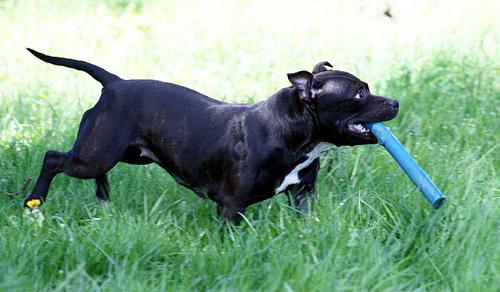

In [11]:
# Load the picture
img = Image.open(pic_sample.pic_full_path.values[0])
# display picture
img

In [12]:
# Get size of picture
sample_w, sample_h = img.size
print("Width : {} px, Height : {} px".format(sample_w, sample_h))

# Print picture's mode
print("Pixels format : {}".format(img.mode))

# Get picture's matrix
sample_mat = np.array(img)

# Display matrix size
print("Size of matrix : {}".format(sample_mat.shape))

Width : 500 px, Height : 292 px
Pixels format : RGB
Size of matrix : (292, 500, 3)


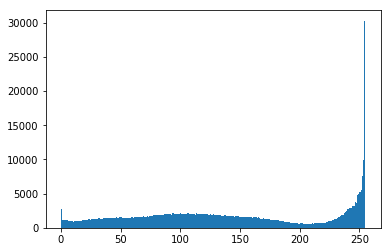

In [13]:
# Generate and display picture's histogram
# For normalized hist : density=True in plt.hist
# For cumulated histogram : cumulative=True
n, bins, patches = plt.hist(sample_mat.flatten(), bins=range(256))

One can notice the extremities pixels with higher values than their neighbors

#### Apply gaussian filter

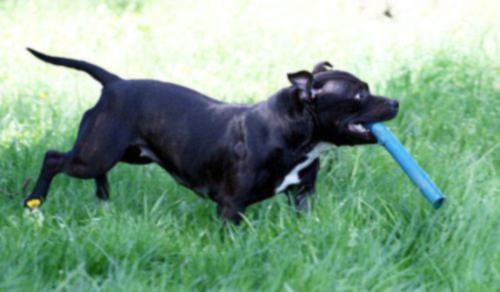

In [14]:
gaussian_img = img.filter(ImageFilter.GaussianBlur(radius=1))
gaussian_img

Gaussian blur as its name implies, blur our picture

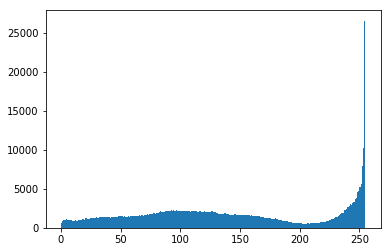

In [15]:
# Histogram of gaussian picture
gaussian_mat = np.array(gaussian_img)
n, bins, patches = plt.hist(gaussian_mat.flatten(), bins=range(256))

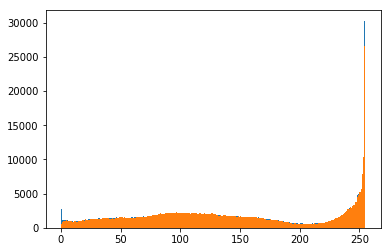

In [16]:
plt.hist(sample_mat.flatten(), bins=range(256));
plt.hist(gaussian_mat.flatten(), bins=range(256));

The gaussian filter reduced our high extremities pixels value to values closer to their neighbors

#### Apply histogram equalization

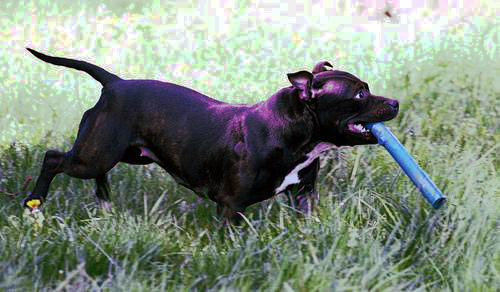

In [17]:
equalized_picture = ImageOps.equalize(img, mask=None)
equalized_picture

Let's look at the histogram of this equalized picture

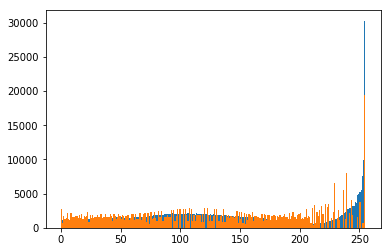

In [18]:
# Histogram of equalized picture
equalized_mat = np.array(equalized_picture)
plt.hist(sample_mat.flatten(), bins=range(256));
plt.hist(equalized_mat.flatten(), bins=range(256));

Equalization completely transformed our picture

#### Apply whitening

In [19]:
# Convert 3D to 2D for covariance computing
rgb_mat = np.hstack([sample_mat[:, :, 0], sample_mat[:, :, 1], sample_mat[:, :, 2]])

In [20]:
sample_mat.shape

(292, 500, 3)

In [21]:
# Scale to 0-1
X_norm = rgb_mat / 255.
# Center matrix
X = X_norm - X_norm.mean(axis=0)

In [22]:
# compute the covariance of the image data
cov = np.cov(X, rowvar=True)   # cov is (N, N)
# singular value decomposition
U, S, V = np.linalg.svd(cov)     # U is (N, N), S is (N,)
# build the ZCA matrix
epsilon = 1e-1
pca_matrix = np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T)
zca_matrix = np.dot(U, pca_matrix)
# transform the image data       zca_matrix is (N,N)
pca = np.dot(pca_matrix, X)    
# zca = np.dot(zca_matrix, X)    # zca is (N, 3072)
zca = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X)

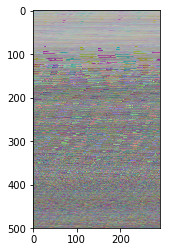

In [23]:
# Small helper function to display picture
def show(i):
    i = i.reshape((sample_w, 3, sample_h)).transpose(0, 2, 1)
    m, M = i.min(), i.max()
    plt.imshow((i - m) / (M - m))
    plt.show()

# show(pca)
show(zca)

Let's look at the histogram of this whitened picture

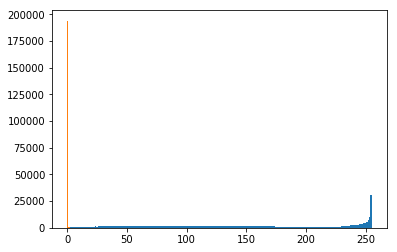

In [24]:
# Histogram of equalized picture
plt.hist(sample_mat.flatten(), bins=range(256));
plt.hist(zca.flatten(), bins=range(256));

Whitening completely transformed our picture, it shifted our histogram to the low values and increased pixels intensity.

#### Get SIFT features

Turn picture to greyscale

In [25]:
grey_pic = cv2.cvtColor(sample_mat, cv2.COLOR_BGR2GRAY)

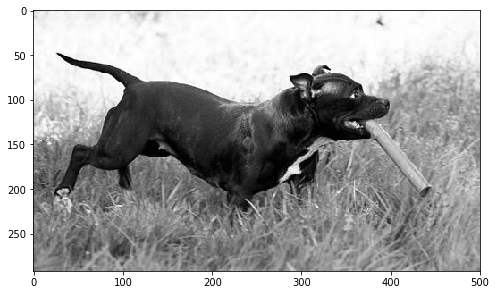

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(grey_pic, cmap='gray');

Generate SIFT features

Here are what our SIFT features look like for the sample image :


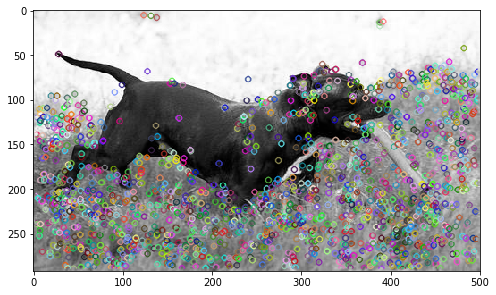

In [27]:
def gen_sift_features(grey_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(grey_img, None)
    return kp, desc

def show_sift_features(grey_img, color_img, kp):  
    fig, ax = plt.subplots(figsize=(8,8))
    return ax.imshow(cv2.drawKeypoints(grey_img, kp, color_img.copy()))

# generate SIFT keypoints and descriptors
image_kp, image_desc = gen_sift_features(grey_pic)

print('Here are what our SIFT features look like for the sample image :')
show_sift_features(grey_pic, sample_mat, image_kp);

In [28]:
print("%i keypoints have been found by the SIFT detector in the picture" % len(image_kp))

1742 keypoints have been found by the SIFT detector in the picture


In [29]:
def explain_keypoint(kp):
    print('angle\n', kp.angle)
    print('\nclass_id\n', kp.class_id)
    print('\noctave (image scale where feature is strongest)\n', kp.octave)
    print('\npt (x,y)\n', kp.pt)
    print('\nresponse\n', kp.response)
    print('\nsize\n', kp.size)

print('this is an example of a single SIFT keypoint:\n* * *')
explain_keypoint(image_kp[0])

this is an example of a single SIFT keypoint:
* * *
angle
 52.73907470703125

class_id
 -1

octave (image scale where feature is strongest)
 3277311

pt (x,y)
 (2.548959732055664, 208.03672790527344)

response
 0.016925128176808357

size
 1.8790616989135742


In [30]:
print('SIFT descriptors are vectors of shape', image_desc[0].shape)
print('they look like this:')
image_desc[0]

SIFT descriptors are vectors of shape (128,)
they look like this:


array([ 41.,  31.,   2.,   1.,   0.,   5.,  36.,  50.,  70.,  20.,   0.,
         0.,   0.,  12.,  77., 134.,  73.,   8.,  11.,  11.,  17.,  38.,
        56.,  53.,  13.,   5.,  23.,  23.,  84., 104.,   8.,   4.,  60.,
        51.,   1.,   0.,   0.,   4.,  21.,  22., 134.,  62.,   0.,   0.,
         9.,  21.,  22.,  80.,  45.,   7.,  15.,  33., 134., 133.,  32.,
        20.,   2.,  14.,  60.,  43.,  42.,  38.,  64.,  14.,  16.,   0.,
         0.,   0.,   0.,   0.,   6.,  15., 134.,  62.,   2.,   1.,   7.,
         3.,   2.,  31.,  53.,  33.,   9.,  29., 134.,  80.,  17.,   8.,
         3.,  19.,  49.,  16.,  22.,  35., 131.,  26.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,  10.,   1.,   0.,   0.,   1.,   0.,
         0.,   3.,   7.,   2.,   8.,  54.,  64.,   2.,   0.,   4.,   1.,
        17., 131.,  60.,  16.,   0.,   0.,   0.], dtype=float32)

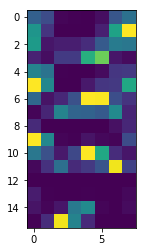

In [31]:
# Having a look at our descriptors
plt.imshow(image_desc[0].reshape(16,8), interpolation='none');

#### Gather our features in bag of visuals words through kmeans clustering

In [32]:
n_clust = int(np.floor(np.sqrt(len(image_desc))))

In [33]:
kmeans = cluster.KMeans(n_clusters=n_clust)
kmeans.fit(image_desc);

The clusters centers are our visual words

In [34]:
kmeans.cluster_centers_

array([[19.446423 , 15.17858  , 16.767853 , ..., 17.321428 , 13.410716 ,
        12.232145 ],
       [21.777773 , 44.888893 , 32.77778  , ...,  8.518517 ,  8.851852 ,
        23.851852 ],
       [15.375    , 30.249998 , 51.32499  , ...,  4.4249973,  4.199997 ,
        14.25     ],
       ...,
       [18.63636  , 39.45455  , 38.97727  , ...,  9.840906 ,  9.272726 ,
        16.840908 ],
       [89.53848  , 59.7436   , 18.333332 , ...,  7.717946 ,  7.7179475,
        19.23077  ],
       [36.96875  , 30.374998 , 17.828121 , ..., 32.82812  , 21.562494 ,
        18.234375 ]], dtype=float32)

Classify our features locally

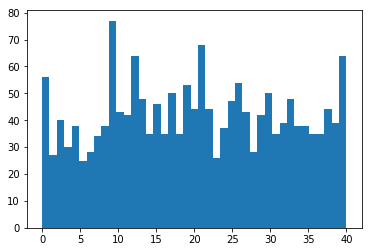

In [35]:
predict_kmeans = kmeans.predict(image_desc)
hist = plt.hist(predict_kmeans, bins=n_clust)

In [36]:
hist

(array([56., 27., 40., 30., 38., 25., 28., 34., 38., 77., 43., 42., 64.,
        48., 35., 46., 35., 50., 35., 53., 44., 68., 44., 26., 37., 47.,
        54., 43., 28., 42., 50., 35., 39., 48., 38., 38., 35., 35., 44.,
        39., 64.]),
 array([ 0.        ,  0.97560976,  1.95121951,  2.92682927,  3.90243902,
         4.87804878,  5.85365854,  6.82926829,  7.80487805,  8.7804878 ,
         9.75609756, 10.73170732, 11.70731707, 12.68292683, 13.65853659,
        14.63414634, 15.6097561 , 16.58536585, 17.56097561, 18.53658537,
        19.51219512, 20.48780488, 21.46341463, 22.43902439, 23.41463415,
        24.3902439 , 25.36585366, 26.34146341, 27.31707317, 28.29268293,
        29.26829268, 30.24390244, 31.2195122 , 32.19512195, 33.17073171,
        34.14634146, 35.12195122, 36.09756098, 37.07317073, 38.04878049,
        39.02439024, 40.        ]),
 <a list of 41 Patch objects>)

### Apply whitening on more pictures

From this post : https://hadrienj.github.io/posts/Preprocessing-for-deep-learning/ we can learn than more pictures improves whitening.

#### Prepare pictures

In [59]:
sample_size = 1000
# Get sub df
sub_df = dogs_df.sample(sample_size, random_state=0)
# Get first picture : reference size for other pictures
first_pic = Image.open(sub_df.pic_full_path.values[0])
first_pic_mat = np.array(first_pic)
pics_mat = first_pic_mat.reshape(1, first_pic_mat.shape[0], first_pic_mat.shape[1], first_pic_mat.shape[2])
# For all sample pictures
for file_path in sub_df.pic_full_path.values[1:]:
    # Load the picture
    pic = Image.open(file_path)
    # Resize picture
    pic_resized = pic.resize((first_pic_mat.shape[1], first_pic_mat.shape[0]), Image.ANTIALIAS)
    # Get picture's matrix
    pic_mat = np.array(pic_resized)
    # Reshape
    pic_mat_resh = pic_mat.reshape(1, first_pic_mat.shape[0], first_pic_mat.shape[1], first_pic_mat.shape[2])
    # Stack
    pics_mat = np.concatenate((pics_mat, pic_mat_resh), axis=0)

In [60]:
# Convert to 2D
X = pics_mat.reshape(pics_mat.shape[0], pics_mat.shape[1] * pics_mat.shape[2] * pics_mat.shape[3])
X.shape

(1000, 562500)

In [61]:
# Visualisation function
def plotImage(X):
    plt.figure(figsize=(5, 5))
    plt.imshow(X.reshape(first_pic_mat.shape[0], first_pic_mat.shape[1], first_pic_mat.shape[2]))
    plt.show()
    plt.close()

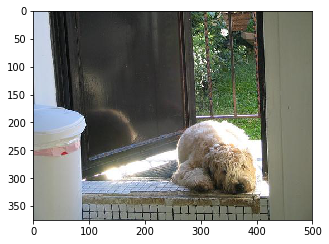

In [62]:
plotImage(X[0,:])

#### Apply whitening

first step is to rescale the images to obtain the range [0, 1] by dividing by 255 (the maximum value of the pixels)

In [63]:
X_norm = X / 255.
print('X.min()', X_norm.min())
print('X.max()', X_norm.max())

X.min() 0.0
X.max() 1.0


Second step is to Subtract the mean from all image

In [64]:
X_norm = X_norm - X_norm.mean(axis=0)
X_norm.mean(axis=0) # Should be close to zero

array([-5.54445378e-16, -5.58886271e-16, -3.32289751e-16, ...,
       -6.60582700e-16, -1.95593541e-16, -2.53519428e-16])

Now we want to calculate the covariance matrix of the zero-centered data

In [65]:
cov = np.cov(X_norm, rowvar=True)
# calculate the singular values and vectors of the covariance matrix and use them to rotate our dataset
U,S,V = np.linalg.svd(cov)

Compute the ZCA matrix

In [66]:
epsilon = 0.01
X_ZCA = U.dot(np.diag(1.0 / np.sqrt(S + epsilon))).dot(U.T).dot(X_norm)

Observe results

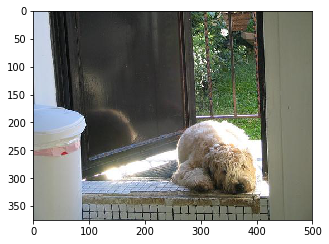

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


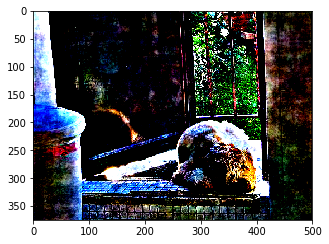

In [67]:
plotImage(X[0, :])
plotImage(X_ZCA[0, :])

Oops need to rescale for visualisation

In [68]:
X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
print('min:', X_ZCA_rescaled.min())
print('max:', X_ZCA_rescaled.max())

min: 0.0
max: 1.0


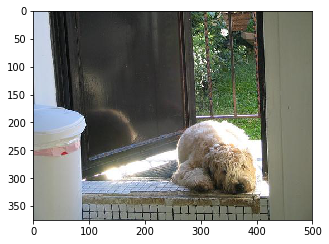

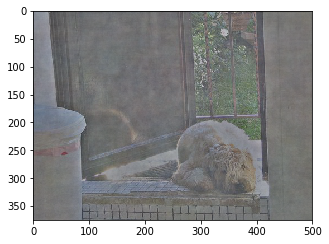

In [69]:
plotImage(X[0, :])
plotImage(X_ZCA_rescaled[0, :])

Let's look at the histogram of this whitened picture

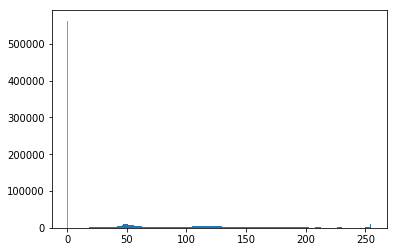

In [70]:
# Histogram of equalized picture
plt.hist(X[0, :].flatten(), bins=range(256));
plt.hist(X_ZCA_rescaled[0, :].flatten(), bins=range(256));

## Put it in a function and play with number of pictures and epsilon

In [49]:
def whitening(pictures_df, n_sample, epsilon):
    """
    Function to play with whitening
    """
    
    # Get sub df
    sub_df = pictures_df.sample(n_sample, random_state=0)
    
    # Get first picture : reference size for other pictures
    first_pic = Image.open(sub_df.pic_full_path.values[0])
    first_pic_mat = np.array(first_pic)
    pics_mat = first_pic_mat.reshape(1, first_pic_mat.shape[0], first_pic_mat.shape[1], first_pic_mat.shape[2])
    
    # For all sample pictures
    for file_path in sub_df.pic_full_path.values[1:]:
        # Load the picture
        pic = Image.open(file_path)
        # Resize picture
        pic_resized = pic.resize((first_pic_mat.shape[1], first_pic_mat.shape[0]), Image.ANTIALIAS)
        # Get picture's matrix
        pic_mat = np.array(pic_resized)
        # Reshape
        pic_mat_resh = pic_mat.reshape(1, first_pic_mat.shape[0], first_pic_mat.shape[1], first_pic_mat.shape[2])
        # Stack
        pics_mat = np.concatenate((pics_mat, pic_mat_resh), axis=0)

    # Convert to 2D
    X = pics_mat.reshape(pics_mat.shape[0], pics_mat.shape[1] * pics_mat.shape[2] * pics_mat.shape[3])
    X.shape

    #### Apply whitening
    
    # First step is to rescale the images to obtain the range [0, 1] by dividing by 255 (max value of the pixels)

    X_norm = X / 255.

    # Second step is to Subtract the mean from all image

    X_norm = X_norm - X_norm.mean(axis=0)
    X_norm.mean(axis=0) # Should be close to zero

    # Now we want to calculate the covariance matrix of the zero-centered data

    cov = np.cov(X_norm, rowvar=True)
    # calculate the singular values and vectors of the covariance matrix and use them to rotate our dataset
    U,S,V = np.linalg.svd(cov)

    # Compute the ZCA matrix

    epsilon = 0.1
    X_ZCA = U.dot(np.diag(1.0 / np.sqrt(S + epsilon))).dot(U.T).dot(X_norm)

    # Return shapes and rescaled pictures for visualisation

    X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
    shapes = first_pic_mat.shape
    
    return X, X_ZCA_rescaled, shapes

In [50]:
# Visualisation function
def plotImageAxes(X, axes, shapes):
    axes.imshow(X.reshape(shapes[0], shapes[1], shapes[2]))
    return axes

Look at number of pictures influence on whitening

In [51]:
# Set params
sample_size = np.arange(2, 602, 100)
epsilon_param = 1e-1
# [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

# Initialize outputs
pictures = []
whitened_pictures = []

# Apply whitening
for param in sample_size:
    dynamic_std_print("Computing with parameter {} with max {}   ".format(param, sample_size.max()))
    out_pics, out_whitened_pics, shapes = whitening(dogs_df, param, epsilon_param)
    pictures.append(out_pics)
    whitened_pictures.append(out_whitened_pics)

Computing with parameter 502 with max 502   

Show Reference :

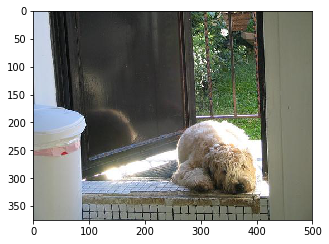

In [52]:
plotImage(pictures[0][0, :])

Show whitening result

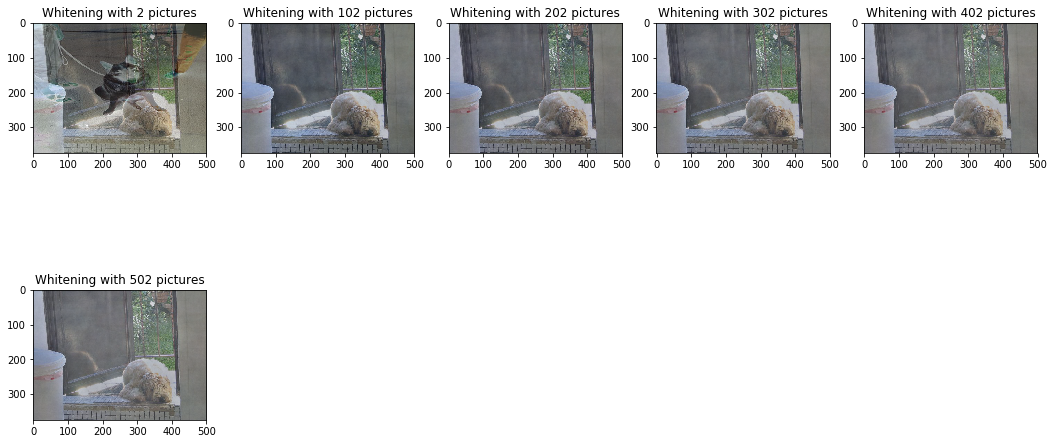

In [53]:
window_size = 3
n_col = 5
fig = plt.figure(figsize=(window_size * len(whitened_pictures), window_size * (np.ceil(len(whitened_pictures) / n_col) + 1)))
for res_pic, count, param in zip(whitened_pictures, range(1, len(whitened_pictures) + 1), sample_size):
    ax = fig.add_subplot(np.ceil(len(whitened_pictures) / n_col), n_col, count)
    ax = plotImageAxes(res_pic[0,:], ax, shapes)
    ax.set_title("Whitening with %i pictures" % param)

Look at epsilon influence on whitening

In [55]:
# Set params
sample_size = 100
epsilon_param = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

# Initialize outputs
pictures = []
whitened_pictures = []

# Apply whitening
for param in epsilon_param:
    dynamic_std_print("Computing with parameter {} with max {}   ".format(param, max(epsilon_param)))
    out_pics, out_whitened_pics, shapes = whitening(dogs_df, sample_size, param)
    pictures.append(out_pics)
    whitened_pictures.append(out_whitened_pics)

Computing with parameter 1e-06 with max 0.1    

Show Reference :

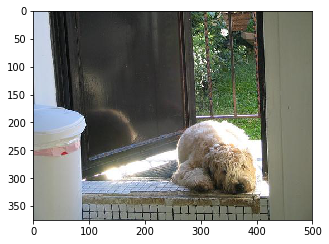

In [56]:
plotImage(pictures[0][0, :])

Show whitening result

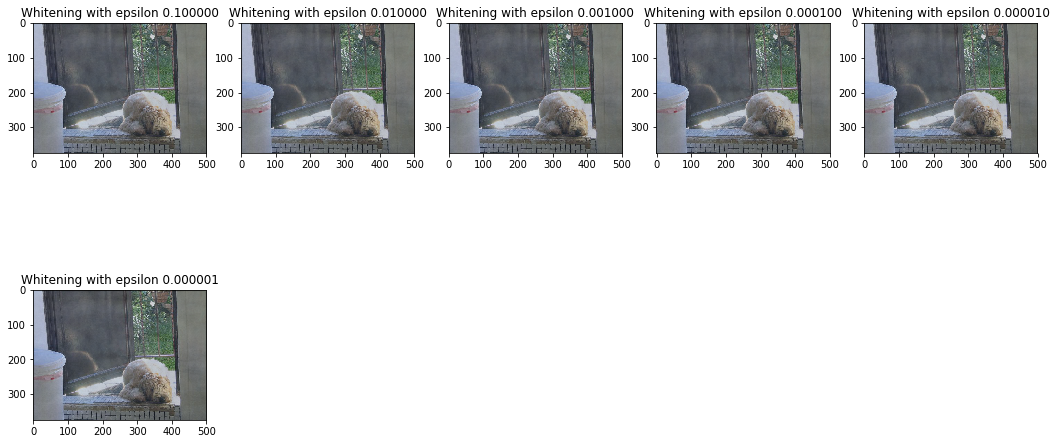

In [58]:
window_size = 3
n_col = 5
fig = plt.figure(figsize=(window_size * len(whitened_pictures), window_size * (np.ceil(len(whitened_pictures) / n_col) + 1)))
for res_pic, count, param in zip(whitened_pictures, range(1, len(whitened_pictures) + 1), epsilon_param):
    ax = fig.add_subplot(np.ceil(len(whitened_pictures) / n_col), n_col, count)
    ax = plotImageAxes(res_pic[0,:], ax, shapes)
    ax.set_title("Whitening with epsilon %f" % param)